In [33]:
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
working_OS = 'Windows'

if working_OS == 'MacOS':
    os.chdir(r"/Users/jordanlee/Code/School/CSCI416/music-genre-classification")
    print("Current Working Directory:", os.getcwd())

elif working_OS == 'Windows':
    os.chdir(r"C:\Code\School\CSCI416\music_genre_classification\music-genre-classification")
    print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Code\School\CSCI416\music_genre_classification\music-genre-classification


# Raw Data Test

In [4]:
# Load the CSV
data_path = 'data/features/features.csv'
df = pd.read_csv(data_path)

# Strip brackets and convert to float where applicable
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column is a string
        try:
            df[col] = df[col].str.strip('[]').astype(float)  # Remove brackets and convert to float
        except ValueError:
            print(f"Skipping column '{col}' as it contains non-numeric data.")

# Save the cleaned data back to CSV (optional)
df.to_csv('data/features/features_cleaned.csv', index=False)

Skipping column 'label' as it contains non-numeric data.


In [5]:
df = pd.read_csv('data/features/features_cleaned.csv')
print(df.head())

   length  chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var  label
0  661794          0.350129         0.088772  ...     1.222467   46.941350  blues
1  661794          0.340849         0.094976  ...     0.530645   45.788700  blues
2  661794          0.363538         0.085257  ...    -2.238128   30.653150  blues
3  661794          0.404854         0.093999  ...    -3.405046   31.965258  blues
4  661794          0.308526         0.087843  ...   -11.704385   55.190254  blues

[5 rows x 59 columns]


In [6]:
X = df.drop(columns=['label'])
y = df['label']

In [7]:
label_encoder =LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
def optimize_rf_hyperparameters(X, y):
    # Create a pipeline that includes scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    
    # Parameter grid for Random Forest
    param_dist = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42
    )
    
    # Fit on the original X and y (scaling happens inside the pipeline)
    random_search.fit(X, y)
    
    print("Best parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_

optimize_rf_hyperparameters(X_scaled, y_encoded)

In [35]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, random_state=42)

In [ ]:
def optimize_svm_hyperparameters(X, y):
    # Create a pipeline that includes scaling and SVM
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Comprehensive parameter grid for SVM
    param_dist = {
        'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
        'svm__kernel': ['rbf', 'linear', 'poly'],  # Kernel types
        'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
        'svm__class_weight': [None, 'balanced'],
        'svm__degree': [2, 3, 4]  # For polynomial kernel
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        svm_pipeline, 
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings to sample
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        random_state=42,
        verbose=2  # Show progress
    )
    
    # Fit on the data
    random_search.fit(X, y)
    
    # Print results
    print("Best SVM parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_

# Usage
best_svm = optimize_svm_hyperparameters(X, y_encoded)

In [42]:
svm_model = SVC(kernel='rbf', gamma=0.01, degree=4, class_weight='balanced', C= 100, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', degree=4, gamma=0.01, probability=True,
    random_state=42)

Best SVM parameters: {'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__degree': 4, 'svm__class_weight': 'balanced', 'svm__C': 100}
Best cross-validated score: 0.6095628140703517

In [51]:
joblib.dump(rf_model, 'models/raw_random_forest_model.joblib')
joblib.dump(svm_model, 'models/raw_svm_model.joblib')

['models/raw_svm_model.joblib']

In [36]:
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.75      1.00      0.86        12
           2       0.78      0.75      0.77        24
           3       0.95      0.82      0.88        22
           4       0.71      0.80      0.75        15
           5       0.96      0.93      0.94        27
           6       0.86      1.00      0.92        18
           7       0.81      0.89      0.85        19
           8       0.76      0.73      0.74        22
           9       0.59      0.50      0.54        20

    accuracy                           0.81       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy: 0.815


In [43]:
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.85      0.92      0.88        12
           2       0.70      0.79      0.75        24
           3       0.65      0.68      0.67        22
           4       0.71      0.80      0.75        15
           5       0.88      0.85      0.87        27
           6       0.88      0.83      0.86        18
           7       0.89      0.84      0.86        19
           8       0.68      0.59      0.63        22
           9       0.50      0.45      0.47        20

    accuracy                           0.75       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.75      0.75       200

Accuracy: 0.75


In [15]:
label_names = sorted(df['label'].unique())

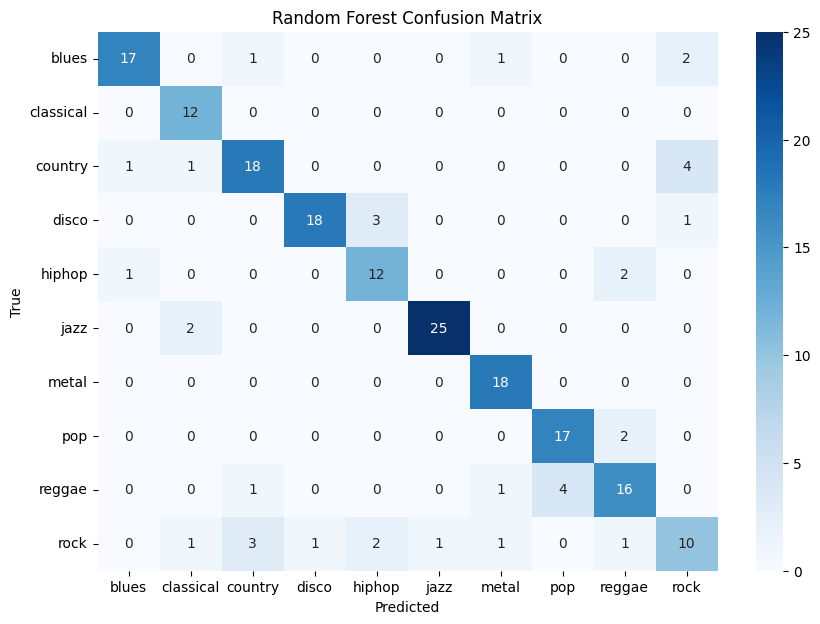

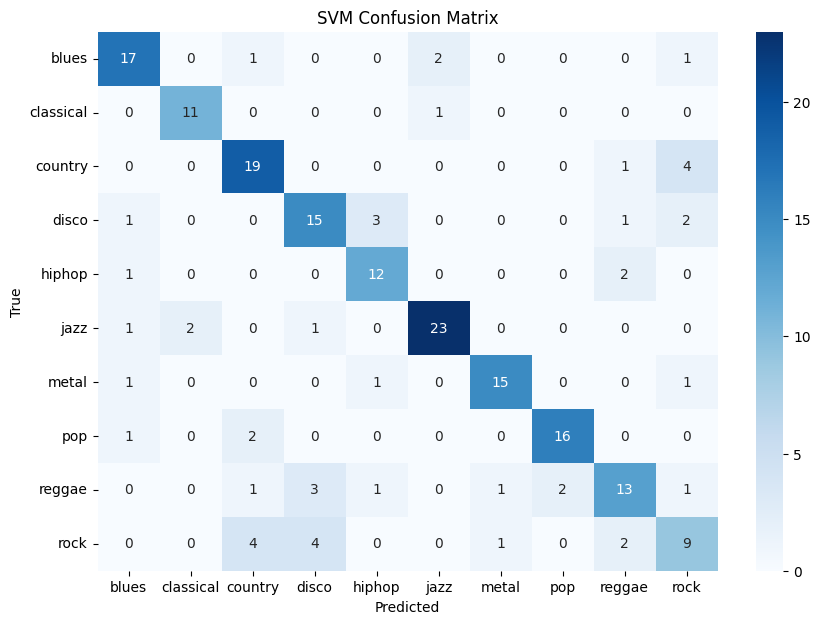

In [44]:
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Generate confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

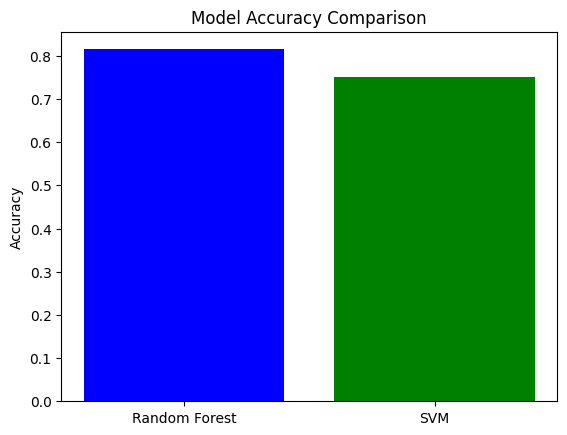

In [45]:
# Calculate accuracy for each model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Create a bar plot for comparison
models = ['Random Forest', 'SVM']
accuracies = [accuracy_rf, accuracy_svm]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

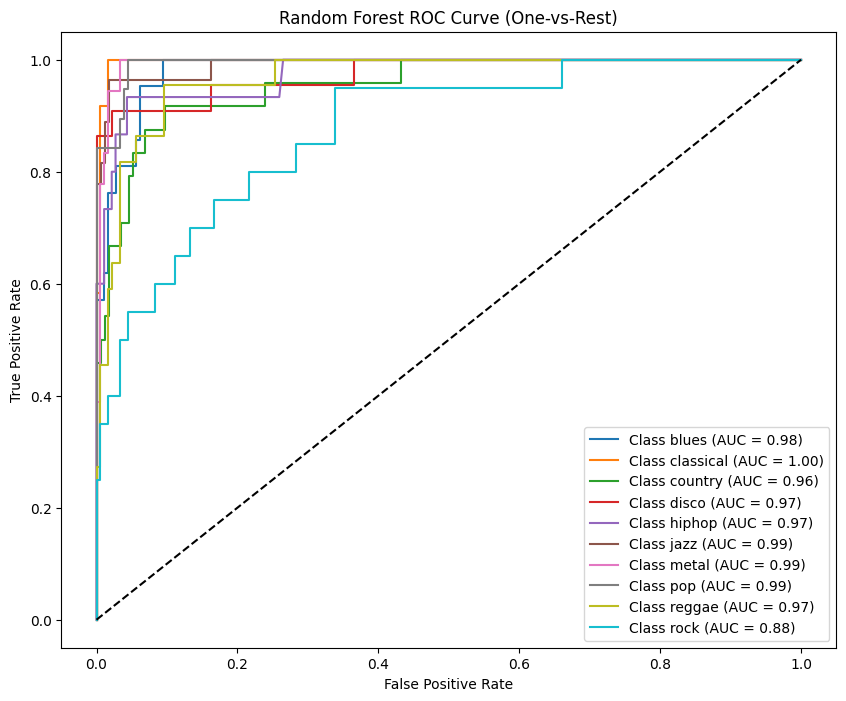

In [46]:
# For Random Forest
n_classes = len(label_names)  # Number of classes (genres)
y_score_rf = rf_model.predict_proba(X_test)  # Get probabilities for each class

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_score_rf[:, i])  # One-vs-Rest
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

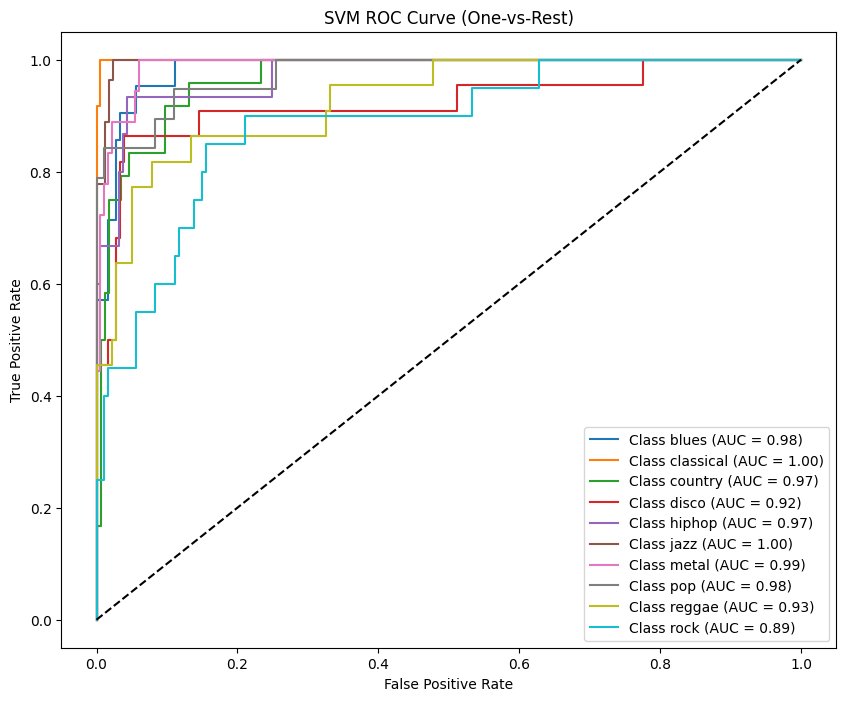

In [47]:
# For SVM
y_score_svm = svm_model.predict_proba(X_test)  # Get probabilities for each class

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_score_svm[:, i])  # One-vs-Rest
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

In [20]:
# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forest CV Scores:", cv_scores_rf)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5)
print("SVM CV Scores:", cv_scores_svm)

Random Forest CV Scores: [0.76875    0.79375    0.775      0.7625     0.75471698]
SVM CV Scores: [0.65625    0.71875    0.75       0.66875    0.67295597]
